#### Data 620 - Project 1 <br>June 19, 2019<br>Team 2: <ul> <li>Anthony Munoz</li> <li>Katie Evers</li> <li>Juliann McEachern</li> <li>Mia Siracusa</li></ul>

<h1 align="center">"Network Analysis"</h1>

For your first project, you are asked to:
1.  Identify and load a network dataset that has some categorical information available for each node.
2.  For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
3.  Compare your centrality measures across your categorical groups.

For example, using the [dataset](http://researchnews.osu.edu/archive/chains.htm) from a study of romantic relationships among high school students in Columbus, Ohio , you might want to determine if there are any differences in your calculated centrality measures between the two sexes.  You might use a t-test or another statistical measure to support your findings.
You may work in a small group.  Your project should be delivered in an IPython Notebook, and posted in GitHub.  

## Network Dataset Selection

We choose to analyze NYC OpenData's [Women Resources Network Database](https://data.cityofnewyork.us/Social-Services/NYC-Women-s-Resource-Network-Database/pqg4-dm6b). The dataset includes 59 variables by columns and 1,147 rows as of the most recent web update on Nov 7, 2018.

Our focus will be on the identified organizations that serve New York City women and families. We will also be examining this network relationships by **insert variable name here**. Each node contains categorical information on which borough the organization services.



In [388]:
#importing the libraries 
import networkx as nx
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import plotly.offline as pyo
import plotly.plotly as py
import plotly.graph_objs as go

pyo.offline.init_notebook_mode()

# to import the socrata library you have to go to Anaconda terminal and install the package before importing 
# the library can be install using "pip install sodapy"
from sodapy import Socrata
import warnings 
from pandas.plotting import scatter_matrix
import seaborn as sns

#warnings.filterwarnings('ignore') UNHASH AFTER COMPLETION

NYC OpenData was accessed using Socrata API. The Women Resources Network Database then was obtained from the client connection below and stored in a pandas dataframe. Unused columns were dropped and the data was transformed from a wide to long format to show the connection between organization and boroughs. The service classifications were retained as edge attributes. 

In [9]:
client = Socrata("data.cityofnewyork.us",None)
results = pd.DataFrame(client.get("pqg4-dm6b", limit=2000))

# drop unused columns 
unused = ['address1', 'address2', 'bbl', 'bin','borough', 'census_tract', 'nonprofit','fax','is_registered_with_the_attorney_general_s_office','latitude','longitude','location_1','phone', 'city', 'community_board', 'community_council', 'postcode', 'published', 'url', 'nourl','description', 'outsideloc', 'outsidelocdesc', 'nta', 'aging', 'anti_discrimination_human_rights', 'arts_culture', 'child_care_parent_information', 'community_service_volunteerism', 'counseling_support_groups', 'disabilities', 'domestic_violence', 'education', 'employment_job_training', 'health', 'homelessness', 'housing', 'immigration', 'legal_services', 'lesbian_gay_bisexual_and_or_transgender', 'none_of_the_above', 'personal_finance_financial_education', 'veterans_military_families', 'victim_services', 'youth_services','professional_association', 'faith_based_organization','foundation', 'business']
results=results.reindex(results.columns.drop(unused), axis=1)

# reorder columns
org =['organizationname']
boro=['bronx', 'brooklyn', 'manhattan', 'queens', 'staten_island']
gov = ['new_york_city_agency','other_government_organization']


# transform dataframe from wide to long
t = results.melt(id_vars=org+gov, value_vars=boro,
                 var_name='boro').query("value == 'Y'").drop('value', axis=1)

# transform government column
def newcol(row):
    if row['new_york_city_agency'] == "Y":
        val = "Y"
    elif row['other_government_organization'] == "Y":
        val = "Y"
    else:
        val = "N"
    return val

t['gov_agency'] = t.apply(newcol, axis=1)

df = t[['organizationname', 'boro', 'gov_agency']].reset_index().drop('index', axis=1)

# preview dataframe
df.head(10)

print("shape:", df.shape)
print(df['gov_agency'].value_counts())

shape: (1944, 3)
N    1704
Y     240
Name: gov_agency, dtype: int64


In [69]:
results.count()

bronx                            1147
brooklyn                         1147
manhattan                        1147
new_york_city_agency             1147
organizationname                 1147
other_government_organization    1147
queens                           1147
staten_island                    1147
dtype: int64

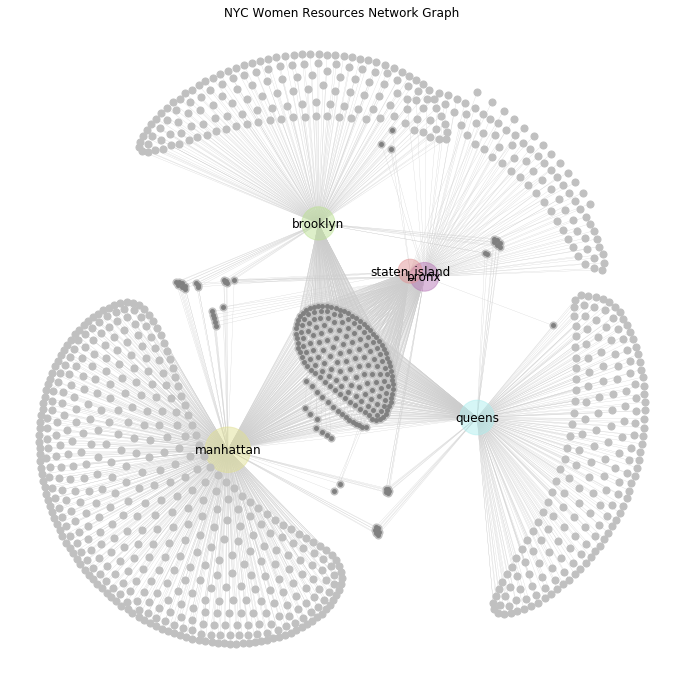

In [15]:
## network lists for later use
org_name = list(df.organizationname.unique())
boro_name = list(df.boro.unique())
boro_color = ['#b878b8', '#bce195', '#e1e095', '#afeeee', '#e19596']

## create graph & set Kamada-Kawai force-directed layout.
plt.figure(figsize=(12, 12))
g = nx.from_pandas_edgelist(df, source='boro', target='organizationname',edge_attr=True)
layout = nx.kamada_kawai_layout(g)

## draw graph
size = [g.degree(boro_name) * 3 for boro_name in boro_name]
nx.draw_networkx_nodes(g, 
                       layout,
                       alpha = .5,
                       nodelist=boro_name, 
                       node_size=size,
                       node_color=boro_color)

nx.draw_networkx_nodes(g, layout, nodelist=org_name, node_color='silver', node_size=50)

# Draw organizations that operate in more than one borough
high_freq_org = [org_name for org_name in org_name if g.degree(org_name) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=high_freq_org, node_color='grey', node_size=15)

nx.draw_networkx_edges(g, layout, width=0.25, edge_color="#cccccc")

node_labels = dict(zip(boro, boro))
nx.draw_networkx_labels(g, layout, labels=node_labels)

## plot graph
plt.axis('off')
plt.title('NYC Women Resources Network Graph')
plt.show()

## Network Analysis

#### Network Information

In [16]:
print(nx.info(g))

print("\nDegrees by Borough: \n",g.degree(boro_name))

Name: 
Type: Graph
Number of nodes: 1138
Number of edges: 1933
Average degree:   3.3972

Degrees by Borough: 
 [('bronx', 276), ('brooklyn', 370), ('manhattan', 692), ('queens', 402), ('staten_island', 193)]


#### Centrality Measures

In [432]:
c = pd.DataFrame()
c['degree'] = nx.degree_centrality(g).values()
c['betweenness'] = nx.betweenness_centrality(g).values()
c['closeness'] = nx.closeness_centrality(g).values()
c['eigen'] = nx.eigenvector_centrality_numpy(g).values() 
c.index = list(g)
c.sort_values(['degree','betweenness','closeness','eigen'],ascending=False)
c.head(10)

degree  betweenness  \
bronx                                               0.242744     0.132343   
RightRides for Women's Safety                       0.003518     0.002051   
American-Italian Cancer Foundation's Mobile Mam...  0.004398     0.002179   
Legal Momentum                                      0.004398     0.002179   
Young Mothers Program/BBBS                          0.004398     0.002179   
Federally Employed Women (FEW)                      0.004398     0.002179   
Sauti Yetu Center for African                       0.004398     0.002179   
National Latina Institute for Reproductive Health   0.004398     0.002179   
American Menopause Foundation                       0.004398     0.002179   
Bronx EOC                                           0.000880     0.000000   

                                                    closeness     eigen  
bronx                                                0.398249  0.267960  
RightRides for Women's Safety                        0.494993  0.038043  
American-Italian Cancer Foundation's Mobile Mam...   0.501102  0.044761  
Legal Momentum                                       0.501102  0.044761  
Young Mothers Program/BBBS                           0.501102  0.044761  
Federally Employed Women (FEW)                       0.501102  0.044761  
Sauti Yetu Center for African                        0.501102  0.044761  
National Latina Institute for Reproductive Health    0.501102  0.044761  
American Menopause Foundation                        0.501102  0.044761  
Bronx EOC                                            0.284891  0.007782

# centrality measures comparing

## closeness

In [278]:
#The closeness node asc
dat = c.reset_index()
dat.sort_values('closeness' ,ascending = False).head(5)

index    degree  betweenness  \
456                                          manhattan  0.608619     0.671518   
109                                         Baby Buggy  0.004398     0.002179   
126  SATH (Society For Accessible Travel & Hospital...  0.004398     0.002179   
128  Women's Center for Education and Career Advanc...  0.004398     0.002179   
129                              Spoons Across America  0.004398     0.002179   

     closeness  eig_centrality  
456   0.562037        0.439751  
109   0.501102        0.044761  
126   0.501102        0.044761  
128   0.501102        0.044761  
129   0.501102        0.044761

In [415]:
#counting and added to dataframe the the close nodes count 
closeness = pd.DataFrame(dat.groupby('closeness').count()['degree']).sort_values('degree' ,ascending = False).reset_index().rename(columns = {"closeness":"closeness","degree":"count"})
closeness.head(5)



closeness  count
0   0.359924    468
1   0.304092    192
2   0.501102    168
3   0.298974    154
4   0.284891     70

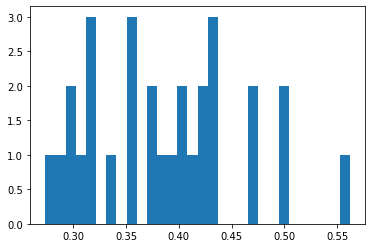

In [359]:
#showing the data distribution on histogram 
plt.hist(closeness['closeness'],bins = 30)
plt.show()

## degree

In [287]:
dat.sort_values('degree' ,ascending = False).head(5)

index    degree  betweenness  closeness  eig_centrality
456       manhattan  0.608619     0.671518   0.562037        0.439751
931          queens  0.353562     0.323519   0.436804        0.304203
277        brooklyn  0.325418     0.269642   0.426322        0.297967
0             bronx  0.242744     0.132343   0.398249        0.267960
1124  staten_island  0.169745     0.029982   0.376365        0.231284

In [416]:
degree = pd.DataFrame(dat.groupby('degree').count()['index']).sort_values('index' ,ascending = False).reset_index().rename(columns = {"degree":"degree","index":"count"})
degree.head(5)


degree  count
0  0.000880    897
1  0.004398    168
2  0.001759     28
3  0.002639     20
4  0.003518     20

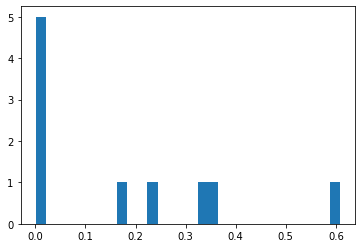

In [356]:
#showing the data distribution on histogram 
plt.hist(degree['degree'],bins = 30)
plt.show()

## eigenvector

In [346]:
dat.sort_values('eigen' ,ascending = False).head(5)

index    degree  betweenness  closeness     eigen
456       manhattan  0.608619     0.671518   0.562037  0.439751
931          queens  0.353562     0.323519   0.436804  0.304203
277        brooklyn  0.325418     0.269642   0.426322  0.297967
0             bronx  0.242744     0.132343   0.398249  0.267960
1124  staten_island  0.169745     0.029982   0.376365  0.231284

In [417]:
eigenvector = pd.DataFrame(dat.groupby('eigen').count()['degree']).sort_values('degree' ,ascending = False).reset_index().rename(columns = {"degree":"degree","degree":"count"})
eigenvector.head(5)


eigen  count
0  0.044761     67
1  0.012772     61
2  0.012772     55
3  0.012772     49
4  0.012772     37

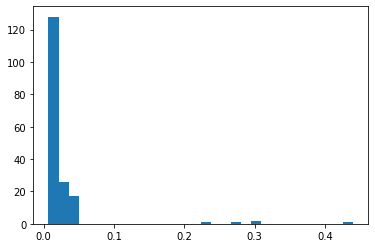

In [354]:
#showing the data distribution on histogram 
plt.hist(eigenvector['eigen'],bins = 30)
plt.show()

## betweeness

In [286]:
dat.sort_values('betweenness' ,ascending = False).head(5)

index    degree  betweenness  closeness  eig_centrality
456       manhattan  0.608619     0.671518   0.562037        0.439751
931          queens  0.353562     0.323519   0.436804        0.304203
277        brooklyn  0.325418     0.269642   0.426322        0.297967
0             bronx  0.242744     0.132343   0.398249        0.267960
1124  staten_island  0.169745     0.029982   0.376365        0.231284

In [418]:
betweenness = pd.DataFrame(dat.groupby('betweenness').count()['degree']).sort_values('degree' ,ascending = False).reset_index().rename(columns = {"degree":"degree","degree":"count"})
betweenness.head(5)


betweenness  count
0     0.000000    897
1     0.002179    168
2     0.002051     15
3     0.000577      7
4     0.000269      6

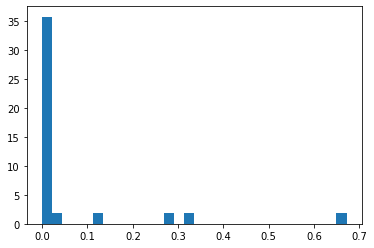

In [353]:
#showing the data distribution on histogram 
plt.hist(betweenness['betweenness'],bins = 30,normed=True)
plt.show()

In [431]:
#subsetting the dataframe 
su_df = dat[['degree','betweenness','closeness','eigen']]
su_df.head()

degree  betweenness  closeness     eigen
0  0.242744     0.132343   0.398249  0.267960
1  0.003518     0.002051   0.494993  0.038043
2  0.004398     0.002179   0.501102  0.044761
3  0.004398     0.002179   0.501102  0.044761
4  0.004398     0.002179   0.501102  0.044761

In [427]:
# correlation between the measures centrality 
su_df.corr()

degree  betweenness  closeness     eigen
degree       1.000000     0.970817   0.140233  0.857442
betweenness  0.970817     1.000000   0.127033  0.788120
closeness    0.140233     0.127033   1.000000  0.585895
eigen        0.857442     0.788120   0.585895  1.000000

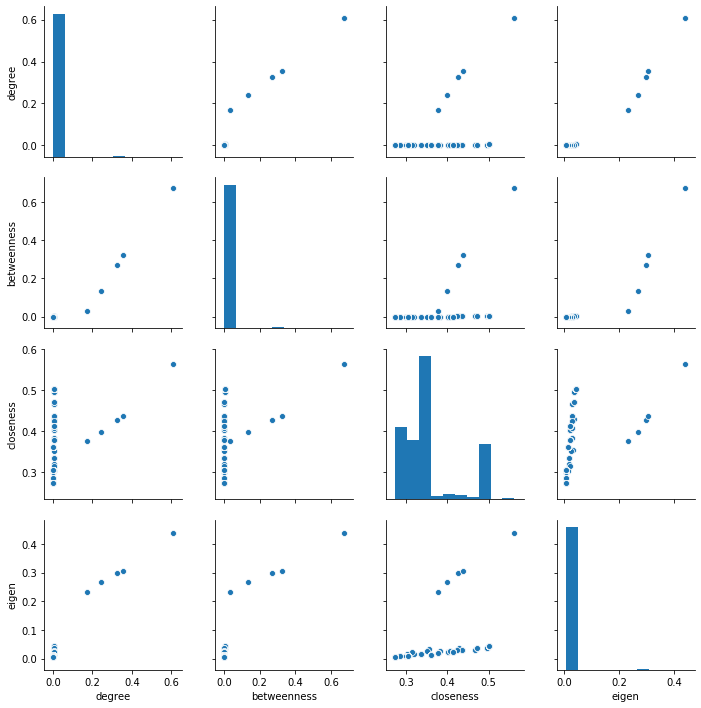

In [433]:
#graph for observing the correlation between the measures centrality
sns.pairplot(dat)


After a look at the 4 centrality measures, we can see that the data result is not normally distributed. for analysis purpose, we did correlation analysis on the 4 centrality measure to see if they could be a relation between them.
we find down that between "degree" and "betweenness" they are a very strong positive (0.970817) and that "closeness" and "betweenness"(0.127033) has the weakest relationship when it comes to correlation variables.